In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

In [2]:
import numpy as np

In [3]:
animal = pd.read_csv("../data/animal_smiles_r_v3.csv")
animal = animal[animal["smiles_r"]!="Cannot_do"].reset_index(drop=True)


monkey = animal[["InChICode_standardised",  "smiles_r", "monkey_VDss_L_kg", "monkey_CL_mL_min_kg", "monkey_fup"]].dropna(subset=[ "monkey_VDss_L_kg", "monkey_CL_mL_min_kg", "monkey_fup"], how="all").reset_index(drop=True)

In [4]:
monkey

,InChICode_standardised,smiles_r,monkey_VDss_L_kg,monkey_CL_mL_min_kg,monkey_fup
0,InChI=1S/C5H3N4S/c10-5-3-4(7-1-6-3)8-2-9-5/h1-...,S=c1nc[n-]c2nc[n-]c12,0.90,15.2,NaN
1,InChI=1S/C8H9NO2/c1-6(10)9-7-2-4-8(11)5-3-7/h2...,CC(=O)Nc1ccc([O-])cc1,NaN,7.3,NaN
2,InChI=1S/C5H7ClN2O3/c6-3-1-2(11-8-3)4(7)5(9)10...,[NH3+]C(C(=O)[O-])[C@@H]1CC(Cl)=NO1,0.61,2.3,NaN
3,InChI=1S/C23H35N3O/c1-17(2)25(18(3)4)16-14-23(...,CC1=[NH+]C(=O)[C@](CC[NH+](C(C)C)C(C)C)(c2cccc...,1.60,20.0,0.6556
4,InChI=1S/C8H11N5O3/c9-8-11-6-5(7(15)12-8)10-3-...,Nc1nc(=O)c2ncn(COCCO)c2[n-]1,0.90,8.8,NaN
...,...,...,...,...,...
123,InChI=1S/C17H27NO2/c1-18(2)13-16(17(19)11-5-4-...,COc1ccc(C(C[NH+](C)C)C2(O)CCCCC2)cc1,3.50,41.0,0.7080
124,"InChI=1S/C27H38N2O4/c1-20(2)27(19-28,22-10-12-...",COc1ccc(CC[NH+](C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C...,5.35,22.8,0.3410
125,InChI=1S/C17H25N3O2/c18-9-14-2-1-3-20(14)15(21...,N#C[C@@H]1CCC[NH+]1C(=O)C[NH2+]C12CC3CC(CC(O)(...,0.70,25.0,0.9597
126,InChI=1S/C9H13N3O3/c10-7-3-4-12(9(14)11-7)8-2-...,Nc1ccn([C@H]2CC[C@@H](CO)O2)c(=O)n1,0.98,10.3,NaN


In [5]:
inchi = monkey[["InChICode_standardised", "smiles_r"]]
for endpoint in ["monkey_VDss_L_kg","monkey_CL_mL_min_kg"]:
    print("Transformed endpoint to log base 10")
    monkey[endpoint] = np.log10(monkey[endpoint])
monkey

Transformed endpoint to log base 10
Transformed endpoint to log base 10


,InChICode_standardised,smiles_r,monkey_VDss_L_kg,monkey_CL_mL_min_kg,monkey_fup
0,InChI=1S/C5H3N4S/c10-5-3-4(7-1-6-3)8-2-9-5/h1-...,S=c1nc[n-]c2nc[n-]c12,-0.045757,1.181844,NaN
1,InChI=1S/C8H9NO2/c1-6(10)9-7-2-4-8(11)5-3-7/h2...,CC(=O)Nc1ccc([O-])cc1,NaN,0.863323,NaN
2,InChI=1S/C5H7ClN2O3/c6-3-1-2(11-8-3)4(7)5(9)10...,[NH3+]C(C(=O)[O-])[C@@H]1CC(Cl)=NO1,-0.214670,0.361728,NaN
3,InChI=1S/C23H35N3O/c1-17(2)25(18(3)4)16-14-23(...,CC1=[NH+]C(=O)[C@](CC[NH+](C(C)C)C(C)C)(c2cccc...,0.204120,1.301030,0.6556
4,InChI=1S/C8H11N5O3/c9-8-11-6-5(7(15)12-8)10-3-...,Nc1nc(=O)c2ncn(COCCO)c2[n-]1,-0.045757,0.944483,NaN
...,...,...,...,...,...
123,InChI=1S/C17H27NO2/c1-18(2)13-16(17(19)11-5-4-...,COc1ccc(C(C[NH+](C)C)C2(O)CCCCC2)cc1,0.544068,1.612784,0.7080
124,"InChI=1S/C27H38N2O4/c1-20(2)27(19-28,22-10-12-...",COc1ccc(CC[NH+](C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C...,0.728354,1.357935,0.3410
125,InChI=1S/C17H25N3O2/c18-9-14-2-1-3-20(14)15(21...,N#C[C@@H]1CCC[NH+]1C(=O)C[NH2+]C12CC3CC(CC(O)(...,-0.154902,1.397940,0.9597
126,InChI=1S/C9H13N3O3/c10-7-3-4-12(9(14)11-7)8-2-...,Nc1ccn([C@H]2CC[C@@H](CO)O2)c(=O)n1,-0.008774,1.012837,NaN


In [6]:
monkey = monkey.groupby('smiles_r').median().reset_index()
monkey

,smiles_r,monkey_VDss_L_kg,monkey_CL_mL_min_kg,monkey_fup
0,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,1.017033,1.173186,NaN
1,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc(OS(=O)(=O)[O-...,1.322219,1.591065,NaN
2,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...,0.857332,1.556303,0.0099
3,C#C[C@]1(OS(=O)(=O)[O-])CC[C@H]2[C@@H]3CCc4cc(...,0.939519,1.113943,NaN
4,C=C[C@H]1C[NH+]2CC[C@H]1C[C@@H]2[C@@H](O)c1ccn...,0.178977,1.350248,0.2027
...,...,...,...,...
123,[NH3+]C(C(=O)[O-])[C@@H]1CC(Cl)=NO1,-0.214670,0.361728,NaN
124,[NH3+]C1(C(=O)[O-])CC1,-0.142668,0.491362,NaN
125,[NH3+]C1[C@H]2CN(c3nc4c(cc3F)c(=O)c(C(=O)[O-])...,0.285557,0.773055,0.3400
126,[NH3+]CC1(CC(=O)[O-])CCCCC1,-0.187087,0.361728,0.0200


In [7]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

def fs_variance(df, threshold:float=0.05):
    """
    Return a list of selected variables based on the threshold.
    """

    # The list of columns in the data frame
    features = list(df.columns)
    
    # Initialize and fit the method
    vt = VarianceThreshold(threshold = threshold)
    _ = vt.fit(df)
    
    # Get which column names which pass the threshold
    feat_select = list(compress(features, vt.get_support()))
    
    return feat_select

def get_pairwise_correlation(population_df, method="pearson"):
    """Given a population dataframe, calculate all pairwise correlations.
    Parameters
    ----------
    population_df : pandas.core.frame.DataFrame
        Includes metadata and observation features.
    method : str, default "pearson"
        Which correlation matrix to use to test cutoff.
    Returns
    -------
    list of str
        Features to exclude from the population_df.
    """


    # Get a symmetrical correlation matrix
    data_cor_df = population_df.corr(method=method)

    # Create a copy of the dataframe to generate upper triangle of zeros
    data_cor_natri_df = data_cor_df.copy()

    # Replace upper triangle in correlation matrix with NaN
    data_cor_natri_df = data_cor_natri_df.where(
        np.tril(np.ones(data_cor_natri_df.shape), k=-1).astype(np.bool)
    )

    # Acquire pairwise correlations in a long format
    # Note that we are using the NaN upper triangle DataFrame
    pairwise_df = data_cor_natri_df.stack().reset_index()
    pairwise_df.columns = ["pair_a", "pair_b", "correlation"]

    return data_cor_df, pairwise_df

def determine_high_cor_pair(correlation_row, sorted_correlation_pairs):
    """
    Select highest correlated variable given a correlation row with columns:
    ["pair_a", "pair_b", "correlation"]
    For use in a pandas.apply()
    """

    pair_a = correlation_row["pair_a"]
    pair_b = correlation_row["pair_b"]

    if sorted_correlation_pairs.get_loc(pair_a) > sorted_correlation_pairs.get_loc(pair_b):
        return pair_a
    
    else:
        return pair_b
    
def count(pred, true, min, max, endpoint):

    if(endpoint == "monkey_fup"):
        lst = [abs(a/b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    else:
        lst = [abs(10**a/10**b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    return

def calc_gmfe(pred, true, endpoint):
    
    if(endpoint == "monkey_fup"):
        
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        return (10**mean_abs)
    
    else: 
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        
        return (10** mean_abs)
    
    return
                         
def median_fold_change_error(pred, true, endpoint):
                         
    if (endpoint == "monkey_fup"):
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    else:
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    return
                          
def calc_bias(pred, true, endpoint):
                          
    if (endpoint == "monkey_fup"):
        lst = [(a - b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    else:
        lst = [(10**a - 10**b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    return

In [8]:
smiles_r = monkey[["smiles_r"]]
smiles_r

,smiles_r
0,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
1,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc(OS(=O)(=O)[O-...
2,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...
3,C#C[C@]1(OS(=O)(=O)[O-])CC[C@H]2[C@@H]3CCc4cc(...
4,C=C[C@H]1C[NH+]2CC[C@H]1C[C@@H]2[C@@H](O)c1ccn...
...,...
123,[NH3+]C(C(=O)[O-])[C@@H]1CC(Cl)=NO1
124,[NH3+]C1(C(=O)[O-])CC1
125,[NH3+]C1[C@H]2CN(c3nc4c(cc3F)c(=O)c(C(=O)[O-])...
126,[NH3+]CC1(CC(=O)[O-])CCCCC1


In [9]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

print(len(calc.descriptors))

Ser_Mol = monkey['smiles_r'].apply(Chem.MolFromSmiles)

# as pandas
Mordred_table=  calc.pandas(Ser_Mol)

1613


100%|█████████████████████████████████████████| 128/128 [00:01<00:00, 81.07it/s]


In [10]:
Mordred_table = Mordred_table.astype('float')
Mordred_table['smiles_r'] = monkey['smiles_r']

In [11]:
Mordred_table = Mordred_table.dropna(axis='columns')
selected_Features = fs_variance(Mordred_table .iloc[:,:-1], threshold=0.05)
print(len(selected_Features))
new_Mordred_table = Mordred_table [selected_Features]
# Get correlation matrix and lower triangle of pairwise correlations in long format
data_cor_df, pairwise_df = get_pairwise_correlation(population_df=new_Mordred_table)
# Get absolute sum of correlation across features
# The lower the index, the less correlation to the full data frame
# We want to drop features with highest correlation, so drop higher index
variable_cor_sum = data_cor_df.abs().sum().sort_values().index
# And subset to only variable combinations that pass the threshold
pairwise_df = pairwise_df.query("correlation > 0.95")
excluded = pairwise_df.apply(lambda x: determine_high_cor_pair(x, variable_cor_sum), axis="columns")
excluded_features = list(set(excluded.tolist()))
print(len(excluded_features))
new_Mordred_table = new_Mordred_table.drop(excluded_features, axis=1)
max_feature_values = new_Mordred_table.max().abs()
min_feature_values = new_Mordred_table.min().abs()
#outlier_features = max_feature_values[(max_feature_values > 15) | (min_feature_values > 15)].index.tolist()
#print(len(outlier_features))
#new_Mordred_table = new_Mordred_table.drop(outlier_features, axis=1)
new_Mordred_table['smiles_r'] = monkey['smiles_r']
new_Mordred_table

798
419


/tmp/ipykernel_1345975/2489624306.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.tril(np.ones(data_cor_natri_df.shape), k=-1).astype(np.bool)


,nAcid,nBase,SpDiam_A,VE1_A,VE3_A,VR2_A,VR3_A,nBridgehead,nH,nC,...,GGI4,GGI5,GGI6,Diameter,MWC10,SRW09,TSRW10,AMW,mZagreb1,smiles_r
0,1.0,0.0,4.952581,3.888933,2.146592,14.362248,6.544103,0.0,27.0,20.0,...,1.680000,1.861111,0.346122,10.0,11.807615,0.000000,56.111877,6.106156,11.180556,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
1,1.0,0.0,5.167010,4.143526,2.377059,15.144978,6.931277,0.0,23.0,20.0,...,2.178333,1.121667,0.863719,13.0,12.570261,7.234898,76.827534,7.655656,9.604167,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc(OS(=O)(=O)[O-...
2,1.0,0.0,5.164227,4.066097,2.191141,7.841830,5.938972,0.0,23.0,20.0,...,1.898333,0.864722,0.600862,11.0,12.482571,7.234898,72.152610,6.559341,7.291667,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...
3,2.0,0.0,5.196793,4.256250,2.403900,8.930372,6.403066,0.0,22.0,20.0,...,2.813333,1.299167,0.785351,12.0,12.649363,7.247793,76.891228,7.794164,9.604167,C#C[C@]1(OS(=O)(=O)[O-])CC[C@H]2[C@@H]3CCc4cc(...
4,0.0,1.0,4.989896,4.427587,2.363323,7.170811,6.023541,2.0,25.0,20.0,...,1.671111,0.930556,0.487347,12.0,12.138056,0.000000,59.266606,6.636552,7.000000,C=C[C@H]1C[NH+]2CC[C@H]1C[C@@H]2[C@@H](O)c1ccn...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1.0,1.0,4.483692,3.066606,1.215882,3.476762,3.739307,0.0,7.0,5.0,...,0.445000,0.271111,0.000000,6.0,10.600502,6.555357,54.296638,9.889696,5.194444,[NH3+]C(C(=O)[O-])[C@@H]1CC(Cl)=NO1
124,1.0,1.0,4.489867,2.415690,0.525310,2.719752,2.589776,0.0,7.0,4.0,...,0.000000,0.000000,0.000000,3.0,10.647161,7.745436,55.351035,7.217691,3.673611,[NH3+]C1(C(=O)[O-])CC1
125,1.0,1.0,5.123970,4.370094,2.573397,12.750864,7.045409,0.0,15.0,20.0,...,2.685556,1.878889,1.354286,13.0,12.653764,8.303752,87.624449,9.246881,10.666667,[NH3+]C1[C@H]2CN(c3nc4c(cc3F)c(=O)c(C(=O)[O-])...
126,1.0,1.0,4.668828,3.113869,1.318187,3.958995,4.043218,0.0,17.0,9.0,...,0.622222,0.180556,0.080000,6.0,10.762213,0.000000,42.499364,5.900894,4.923611,[NH3+]CC1(CC(=O)[O-])CCCCC1


In [12]:
Ser_Mol = monkey['smiles_r'].apply(Chem.MolFromSmiles)

import numpy as np
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

Morgan_fingerprint= Ser_Mol.apply(GetMorganFingerprintAsBitVect, args=(2, 2048))
Morganfingerprint_array  = np.stack(Morgan_fingerprint)

Morgan_collection  = []
for x in np.arange(Morganfingerprint_array.shape[1]): #np.arange plus rapide que range
    x = "Mfp"+str(x)
    Morgan_collection.append(x)

Morganfingerprint_table  = pd.DataFrame(Morganfingerprint_array , columns=Morgan_collection )
Morganfingerprint_table['smiles_r'] = monkey['smiles_r']

In [13]:
selected_Features = fs_variance(Morganfingerprint_table.iloc[:,:-1], threshold=0.05)
print(len(selected_Features))
new_Morganfingerprint_table= Morganfingerprint_table[selected_Features]
new_Morganfingerprint_table['smiles_r'] = monkey['smiles_r']
new_Morganfingerprint_table

207


/tmp/ipykernel_1345975/2629102146.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_Morganfingerprint_table['smiles_r'] = monkey['smiles_r']


,Mfp1,Mfp13,Mfp41,Mfp80,Mfp114,Mfp116,Mfp117,Mfp118,Mfp140,Mfp146,...,Mfp1928,Mfp1955,Mfp1970,Mfp1991,Mfp2004,Mfp2007,Mfp2010,Mfp2021,Mfp2031,smiles_r
0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc(OS(=O)(=O)[O-...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C#C[C@]1(OS(=O)(=O)[O-])CC[C@H]2[C@@H]3CCc4cc(...
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C=C[C@H]1C[NH+]2CC[C@H]1C[C@@H]2[C@@H](O)c1ccn...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[NH3+]C(C(=O)[O-])[C@@H]1CC(Cl)=NO1
124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[NH3+]C1(C(=O)[O-])CC1
125,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,[NH3+]C1[C@H]2CN(c3nc4c(cc3F)c(=O)c(C(=O)[O-])...
126,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[NH3+]CC1(CC(=O)[O-])CCCCC1


In [14]:
Mordred_columns = new_Mordred_table.columns[:-1].tolist()
mfp_columns = new_Morganfingerprint_table.columns[:-1].tolist()
#Mordred_columns = Mordred_table.columns[:-1].tolist()
#mfp_columns = Morganfingerprint_table.columns[:-1].tolist()

features_mfp_mordred_columns = Mordred_columns + mfp_columns
print(len(features_mfp_mordred_columns))

#Write to file
#len(features_mfp_mordred_columns)
f = open("features_mfp_mordred_columns_monkey_model.txt", "w")
for item in features_mfp_mordred_columns:
   f.write(item + "\n")
f.close()

586


In [15]:
#read from file
file = open("features_mfp_mordred_columns_monkey_model.txt", "r")
file_lines = file.read()
features_mfp_mordred_columns = file_lines.split("\n")
features_mfp_mordred_columns = features_mfp_mordred_columns[:-1]
features_mfp_mordred_columns

['nAcid',
 'nBase',
 'SpDiam_A',
 'VE1_A',
 'VE3_A',
 'VR2_A',
 'VR3_A',
 'nBridgehead',
 'nH',
 'nC',
 'nN',
 'nS',
 'nF',
 'nX',
 'ATS3dv',
 'ATS7dv',
 'ATS2s',
 'ATS3s',
 'ATS4s',
 'ATS5s',
 'ATS6s',
 'ATS7s',
 'ATS8s',
 'ATS6i',
 'ATS8i',
 'AATS0dv',
 'AATS1dv',
 'AATS2dv',
 'AATS3dv',
 'AATS4dv',
 'AATS0d',
 'AATS2d',
 'AATS3d',
 'AATS4d',
 'AATS1s',
 'AATS2s',
 'AATS3s',
 'AATS4s',
 'AATS1Z',
 'AATS0m',
 'AATS3m',
 'AATS4m',
 'AATS0v',
 'AATS3v',
 'AATS4v',
 'AATS1are',
 'AATS3are',
 'AATS4are',
 'AATS0i',
 'AATS1i',
 'AATS2i',
 'AATS3i',
 'AATS4i',
 'ATSC0c',
 'ATSC1c',
 'ATSC2c',
 'ATSC3c',
 'ATSC4c',
 'ATSC5c',
 'ATSC6c',
 'ATSC7c',
 'ATSC8c',
 'ATSC0dv',
 'ATSC1dv',
 'ATSC2dv',
 'ATSC3dv',
 'ATSC4dv',
 'ATSC5dv',
 'ATSC6dv',
 'ATSC7dv',
 'ATSC8dv',
 'ATSC1d',
 'ATSC2d',
 'ATSC3d',
 'ATSC4d',
 'ATSC5d',
 'ATSC6d',
 'ATSC7d',
 'ATSC8d',
 'ATSC1s',
 'ATSC2s',
 'ATSC3s',
 'ATSC4s',
 'ATSC5s',
 'ATSC6s',
 'ATSC7s',
 'ATSC8s',
 'ATSC1Z',
 'ATSC2Z',
 'ATSC6Z',
 'ATSC8Z',
 'ATSC0m',


In [16]:
monkey_mfp = pd.merge(monkey, new_Morganfingerprint_table)
monkey_mfp_Mordred = pd.merge(monkey_mfp, new_Mordred_table)
monkey_mfp_Mordred

#human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
#human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
#human_lombardo_mfp_Mordred

,smiles_r,monkey_VDss_L_kg,monkey_CL_mL_min_kg,monkey_fup,Mfp1,Mfp13,Mfp41,Mfp80,Mfp114,Mfp116,...,GGI3,GGI4,GGI5,GGI6,Diameter,MWC10,SRW09,TSRW10,AMW,mZagreb1
0,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,1.017033,1.173186,NaN,0,0,0,1,1,0,...,2.375000,1.680000,1.861111,0.346122,10.0,11.807615,0.000000,56.111877,6.106156,11.180556
1,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc(OS(=O)(=O)[O-...,1.322219,1.591065,NaN,0,0,0,0,0,0,...,3.263889,2.178333,1.121667,0.863719,13.0,12.570261,7.234898,76.827534,7.655656,9.604167
2,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...,0.857332,1.556303,0.0099,0,0,0,0,0,0,...,2.763889,1.898333,0.864722,0.600862,11.0,12.482571,7.234898,72.152610,6.559341,7.291667
3,C#C[C@]1(OS(=O)(=O)[O-])CC[C@H]2[C@@H]3CCc4cc(...,0.939519,1.113943,NaN,0,0,0,0,0,0,...,3.513889,2.813333,1.299167,0.785351,12.0,12.649363,7.247793,76.891228,7.794164,9.604167
4,C=C[C@H]1C[NH+]2CC[C@H]1C[C@@H]2[C@@H](O)c1ccn...,0.178977,1.350248,0.2027,1,0,0,0,0,0,...,1.625000,1.671111,0.930556,0.487347,12.0,12.138056,0.000000,59.266606,6.636552,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,[NH3+]C(C(=O)[O-])[C@@H]1CC(Cl)=NO1,-0.214670,0.361728,NaN,1,0,0,0,0,0,...,0.847222,0.445000,0.271111,0.000000,6.0,10.600502,6.555357,54.296638,9.889696,5.194444
124,[NH3+]C1(C(=O)[O-])CC1,-0.142668,0.491362,NaN,0,0,0,0,0,0,...,0.444444,0.000000,0.000000,0.000000,3.0,10.647161,7.745436,55.351035,7.217691,3.673611
125,[NH3+]C1[C@H]2CN(c3nc4c(cc3F)c(=O)c(C(=O)[O-])...,0.285557,0.773055,0.3400,0,0,0,0,0,0,...,2.597222,2.685556,1.878889,1.354286,13.0,12.653764,8.303752,87.624449,9.246881,10.666667
126,[NH3+]CC1(CC(=O)[O-])CCCCC1,-0.187087,0.361728,0.0200,0,0,0,1,0,0,...,0.875000,0.622222,0.180556,0.080000,6.0,10.762213,0.000000,42.499364,5.900894,4.923611


monkey_VDss_L_kg
0
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
24
2-fold :  70.83333333333334
3-fold :  79.16666666666666
5-fold :  91.66666666666666
gmfe :  1.8327203328870318
mfe :  1.162140238117927
bias :  -0.028288844843489924
rmse  0.36863621018284576
r2  0.6088306487141066
saving model


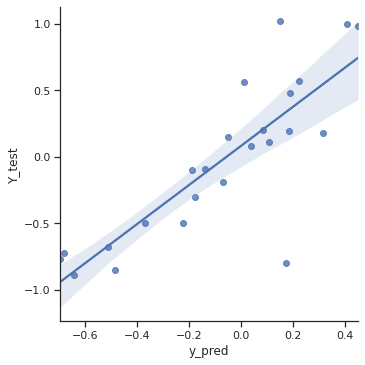

1
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=42)
24
2-fold :  66.66666666666666
3-fold :  75.0
5-fold :  83.33333333333334
gmfe :  2.0725741410455516
mfe :  1.235456347987012
bias :  0.03783360903981242
rmse  0.4475246043995495
r2  0.4707608328507812


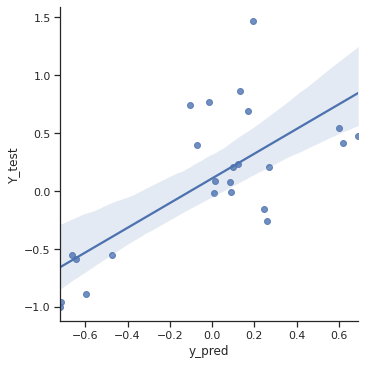

2
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='log2',
                      min_samples_split=8, n_jobs=30, random_state=42)
24
2-fold :  75.0
3-fold :  79.16666666666666
5-fold :  91.66666666666666
gmfe :  1.9841023341338437
mfe :  1.2277092725922116
bias :  0.05132568566519187
rmse  0.42787378697113243
r2  0.5069383437127031


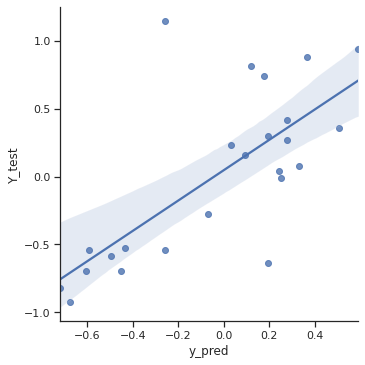

3
(95, 586)
(23, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
23
2-fold :  65.21739130434783
3-fold :  82.6086956521739
5-fold :  86.95652173913044
gmfe :  2.2765838704716423
mfe :  1.263885431217905
bias :  0.2703458452651456
rmse  0.48040170201026205
r2  0.11821604531150365


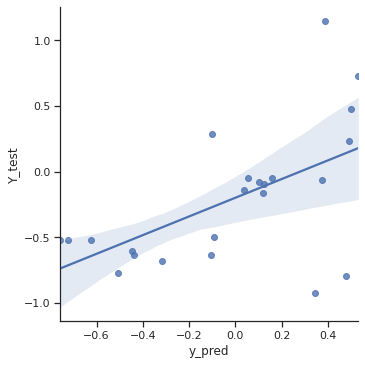

4
(95, 586)
(23, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
23
2-fold :  43.47826086956522
3-fold :  56.52173913043478
5-fold :  82.6086956521739
gmfe :  2.5651736259303366
mfe :  1.5130684915198849
bias :  0.0948832269657175
rmse  0.5046585490358718
r2  0.40872709223316683


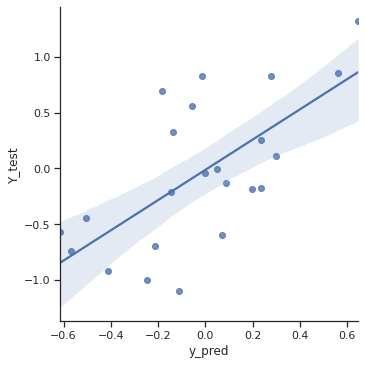

0
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=43)
24
2-fold :  66.66666666666666
3-fold :  83.33333333333334
5-fold :  91.66666666666666
gmfe :  1.916086115832408
mfe :  1.2386423368788904
bias :  0.10131244077964839
rmse  0.389808444214043
r2  0.5587244061884838


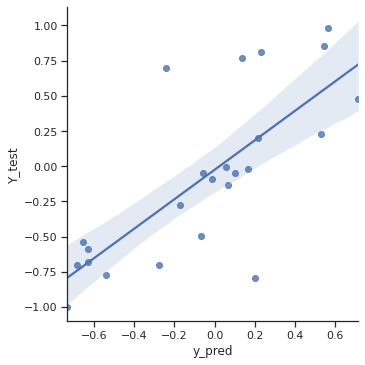

1
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_jobs=30, random_state=43)
24
2-fold :  58.333333333333336
3-fold :  79.16666666666666
5-fold :  91.66666666666666
gmfe :  2.0148621394760893
mfe :  1.322675697406355
bias :  0.05861053346675318
rmse  0.3791688797936993
r2  0.585035213711727


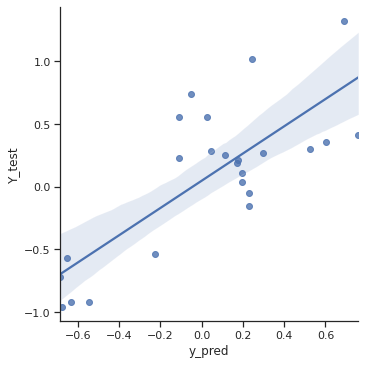

2
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=43)
24
2-fold :  62.5
3-fold :  79.16666666666666
5-fold :  87.5
gmfe :  2.197754423685935
mfe :  1.227770997700629
bias :  0.10448049920552553
rmse  0.4667624514363676
r2  0.47524233434935537


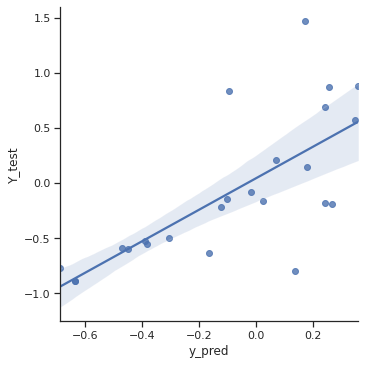

3
(95, 586)
(23, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
23
2-fold :  56.52173913043478
3-fold :  78.26086956521739
5-fold :  86.95652173913044
gmfe :  2.1529589862575365
mfe :  1.2726455193768929
bias :  -0.09228687274708847
rmse  0.4467555318417561
r2  0.47483905972598084


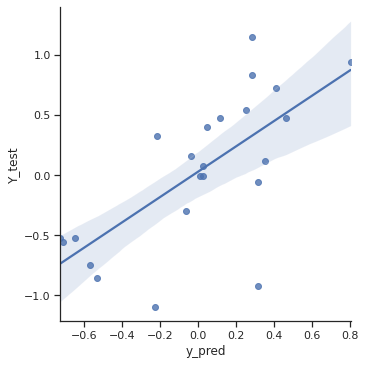

4
(95, 586)
(23, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=43)
23
2-fold :  56.52173913043478
3-fold :  73.91304347826086
5-fold :  86.95652173913044
gmfe :  2.2242999252093365
mfe :  1.2443628897724979
bias :  0.15049723030993617
rmse  0.474147172836318
r2  0.2946295058931264


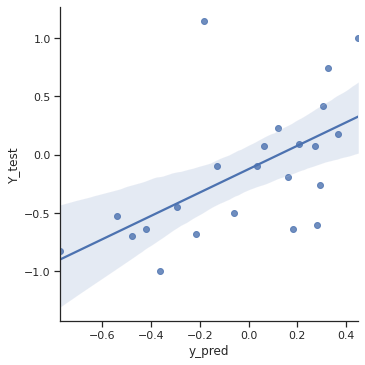

0
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=8, n_jobs=30, random_state=44)
24
2-fold :  75.0
3-fold :  75.0
5-fold :  91.66666666666666
gmfe :  1.9691716827885482
mfe :  1.2112355684903913
bias :  -0.017474153849166382
rmse  0.4272025809899025
r2  0.5135488006886488


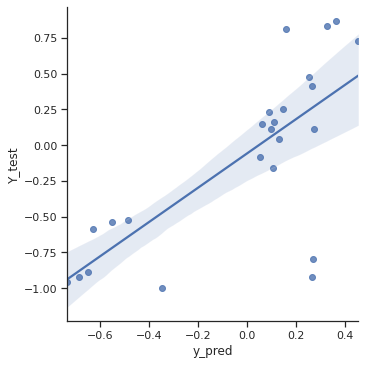

1
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
24
2-fold :  79.16666666666666
3-fold :  83.33333333333334
5-fold :  95.83333333333334
gmfe :  1.6641949659872217
mfe :  1.1935385721218703
bias :  0.053898879807181915
rmse  0.2977221653364767
r2  0.7375462437609765
saving model


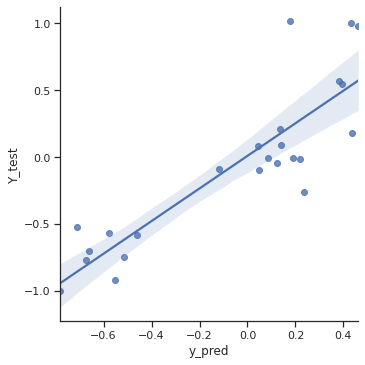

2
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=44)
24
2-fold :  37.5
3-fold :  66.66666666666666
5-fold :  83.33333333333334
gmfe :  2.7436314926613408
mfe :  1.4273209283128618
bias :  0.09740843875425102
rmse  0.5423322127246272
r2  0.2593775733644995


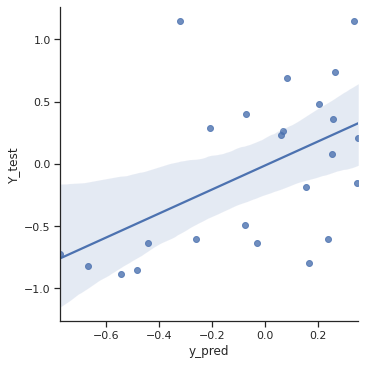

3
(95, 586)
(23, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
23
2-fold :  56.52173913043478
3-fold :  73.91304347826086
5-fold :  86.95652173913044
gmfe :  2.1907705916992266
mfe :  1.2547981123052816
bias :  0.20136889141351555
rmse  0.43076155119164317
r2  0.3218283609592739


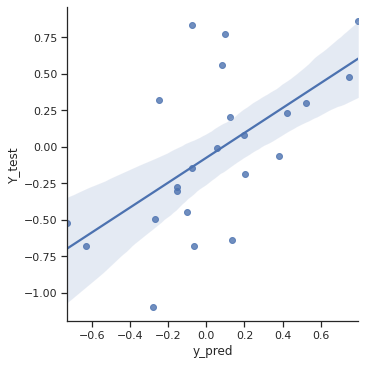

4
(95, 586)
(23, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=44)
23
2-fold :  56.52173913043478
3-fold :  69.56521739130434
5-fold :  82.6086956521739
gmfe :  2.440686662773958
mfe :  1.2899891391777167
bias :  0.023640843267770828
rmse  0.5336457870923963
r2  0.3509388859966309


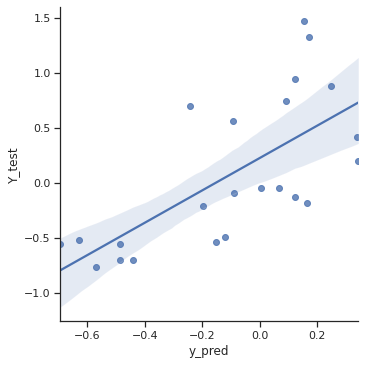

0
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='log2', min_samples_split=8,
                      n_jobs=30, random_state=45)
24
2-fold :  54.166666666666664
3-fold :  79.16666666666666
5-fold :  83.33333333333334
gmfe :  2.168752926164721
mfe :  1.2794306400312994
bias :  0.0748663562941898
rmse  0.44143438386157124
r2  0.5566017649254683


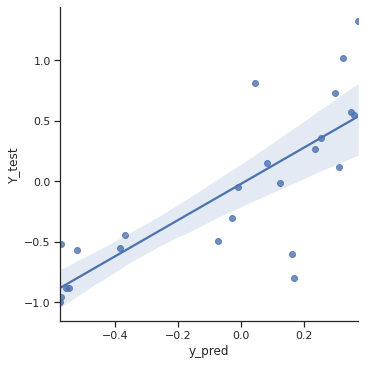

1
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=45)
24
2-fold :  58.333333333333336
3-fold :  75.0
5-fold :  83.33333333333334
gmfe :  2.2513824679664673
mfe :  1.2700450978951112
bias :  -0.07471333500933978
rmse  0.502749112059575
r2  0.11589286484880146


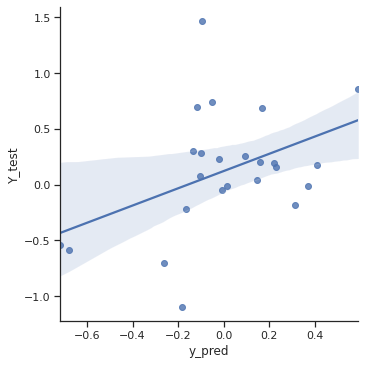

2
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
24
2-fold :  62.5
3-fold :  87.5
5-fold :  91.66666666666666
gmfe :  1.9305818513206525
mfe :  1.2838035264378251
bias :  0.10717831676462856
rmse  0.39535382285951876
r2  0.5321680831564886


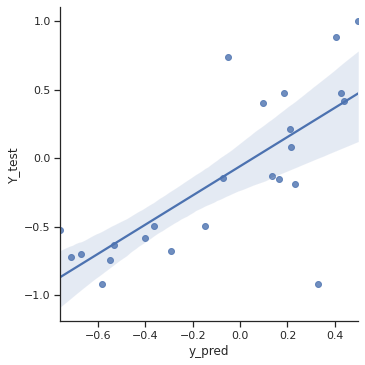

3
(95, 586)
(23, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
23
2-fold :  60.86956521739131
3-fold :  65.21739130434783
5-fold :  86.95652173913044
gmfe :  2.219310518501181
mfe :  1.2329625719178232
bias :  0.05563580932990536
rmse  0.47960706715798324
r2  0.34676790796947765


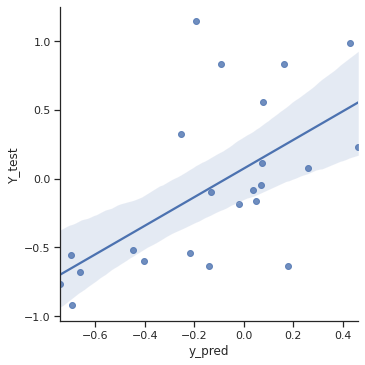

4
(95, 586)
(23, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
23
2-fold :  65.21739130434783
3-fold :  65.21739130434783
5-fold :  86.95652173913044
gmfe :  2.130527446585412
mfe :  1.2091169483381468
bias :  0.023966356726910693
rmse  0.4440419505934125
r2  0.490946900019378


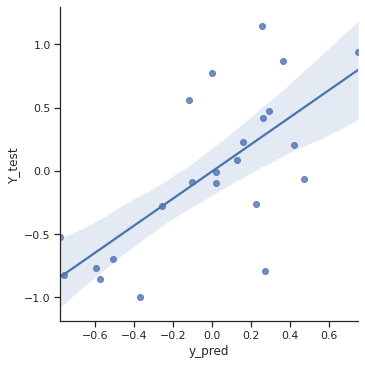

0
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
24
2-fold :  54.166666666666664
3-fold :  75.0
5-fold :  83.33333333333334
gmfe :  2.2773789026179405
mfe :  1.2071844881792813
bias :  0.04491842747806281
rmse  0.5251466741035105
r2  0.3978044621401172


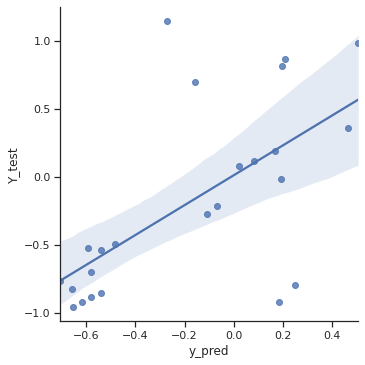

1
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=8, n_jobs=30, random_state=46)
24
2-fold :  50.0
3-fold :  79.16666666666666
5-fold :  91.66666666666666
gmfe :  2.1015551336995135
mfe :  1.332369286504567
bias :  0.15861413249081788
rmse  0.39079744420581125
r2  0.5144846319487181


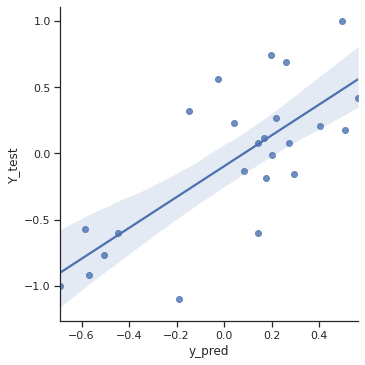

2
(94, 586)
(24, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
24
2-fold :  62.5
3-fold :  75.0
5-fold :  87.5
gmfe :  2.0459977948017305
mfe :  1.2538754624938833
bias :  0.10515748870353674
rmse  0.4226061633102604
r2  0.449289796995923


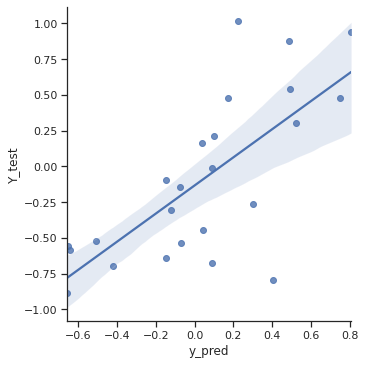

3
(95, 586)
(23, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      n_jobs=30, random_state=46)
23
2-fold :  56.52173913043478
3-fold :  73.91304347826086
5-fold :  86.95652173913044
gmfe :  2.227970917697266
mfe :  1.2545198170560041
bias :  -0.5328395142901341
rmse  0.4639337653096296
r2  0.4456193408820973


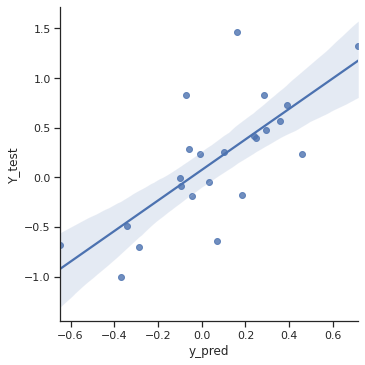

4
(95, 586)
(23, 586)
Running ____________________monkey_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=46)
23
2-fold :  69.56521739130434
3-fold :  82.6086956521739
5-fold :  86.95652173913044
gmfe :  1.8542785386669385
mfe :  1.1896053652804164
bias :  0.02727917571039845
rmse  0.353742566069342
r2  0.558916609161644


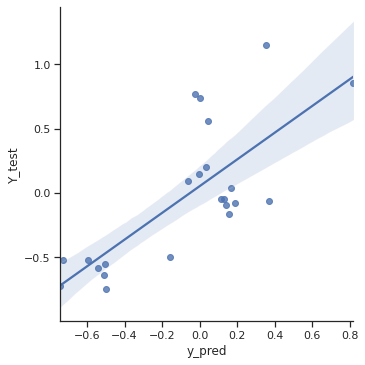

monkey_CL_mL_min_kg
0
(97, 586)
(25, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=8, n_jobs=30, random_state=42)
25
2-fold :  68.0
3-fold :  88.0
5-fold :  96.0
gmfe :  1.7341374168701562
mfe :  1.185436189933821
bias :  -0.3270585361180036
rmse  0.3269531658099987
r2  0.46645729307557104
saving model


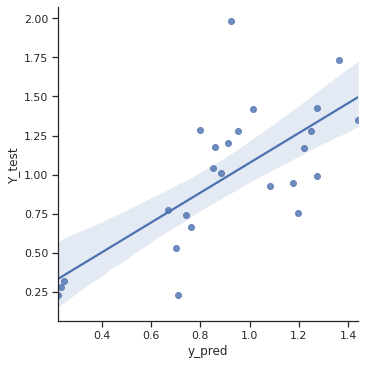

1
(97, 586)
(25, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
25
2-fold :  44.0
3-fold :  72.0
5-fold :  88.0
gmfe :  2.2875975608565358
mfe :  1.3800237895303673
bias :  0.45068841830480655
rmse  0.4527691606887134
r2  0.3489537568328399


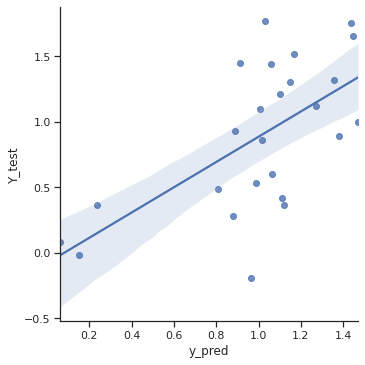

2
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=42)
24
2-fold :  50.0
3-fold :  79.16666666666666
5-fold :  91.66666666666666
gmfe :  2.1277786040306266
mfe :  1.311905807625263
bias :  -0.9741334716679355
rmse  0.4482679746524531
r2  0.5981167550364572


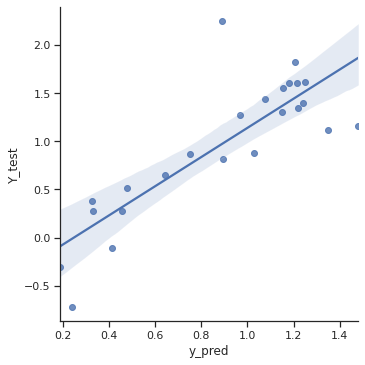

3
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=42)
24
2-fold :  58.333333333333336
3-fold :  70.83333333333334
5-fold :  87.5
gmfe :  2.2695520097070983
mfe :  1.3150709731816521
bias :  0.016797741374739328
rmse  0.5039168311406396
r2  0.10198271266624281


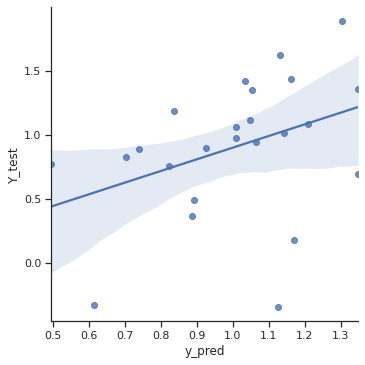

4
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='log2',
                      n_jobs=30, random_state=42)
24
2-fold :  33.33333333333333
3-fold :  75.0
5-fold :  91.66666666666666
gmfe :  2.348557064089891
mfe :  1.3913967269115766
bias :  -0.8189316828377954
rmse  0.4273364193611603
r2  0.16576670862622112


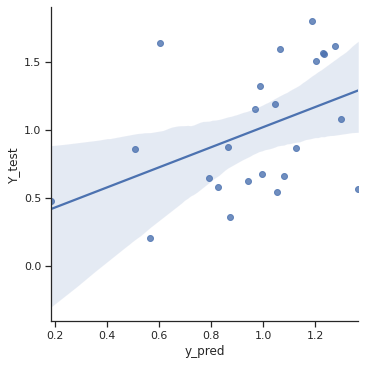

0
(97, 586)
(25, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_jobs=30,
                      random_state=43)
25
2-fold :  48.0
3-fold :  76.0
5-fold :  100.0
gmfe :  2.006864138831549
mfe :  1.392781472124877
bias :  -1.623447387327837
rmse  0.35502620146260444
r2  0.5006622589201847


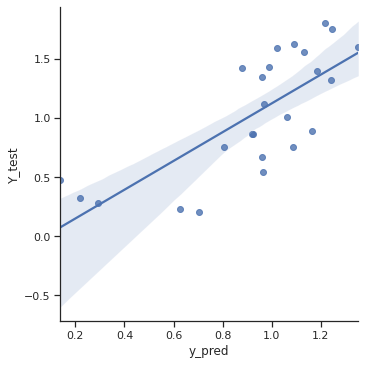

1
(97, 586)
(25, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=43)
25
2-fold :  56.00000000000001
3-fold :  88.0
5-fold :  96.0
gmfe :  1.833974946490681
mfe :  1.2278893578260774
bias :  -0.7831287635242852
rmse  0.3293685191753952
r2  0.33971548094417303


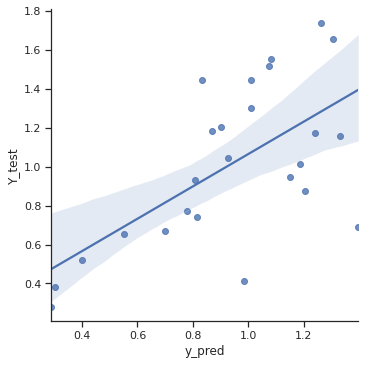

2
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_jobs=30,
                      random_state=43)
24
2-fold :  41.66666666666667
3-fold :  66.66666666666666
5-fold :  91.66666666666666
gmfe :  2.47902597634015
mfe :  1.4085010754447118
bias :  3.2776675816421394
rmse  0.49698499739778235
r2  0.22118354619209635


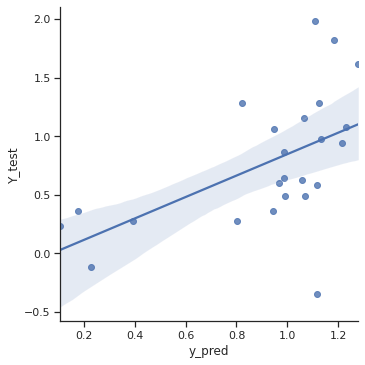

3
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_jobs=30,
                      random_state=43)
24
2-fold :  45.83333333333333
3-fold :  83.33333333333334
5-fold :  91.66666666666666
gmfe :  2.25665878409371
mfe :  1.3559240696687935
bias :  -2.3313811165055776
rmse  0.4495271038240125
r2  0.4193381577517805


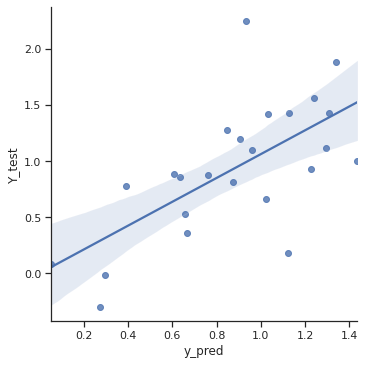

4
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=43)
24
2-fold :  50.0
3-fold :  66.66666666666666
5-fold :  79.16666666666666
gmfe :  2.5250618274151337
mfe :  1.3522378558517993
bias :  -1.2056196564301338
rmse  0.5084962386178195
r2  0.36184243057447363


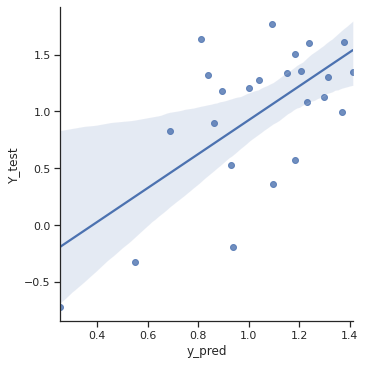

0
(97, 586)
(25, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
25
2-fold :  52.0
3-fold :  88.0
5-fold :  92.0
gmfe :  1.9287982687199563
mfe :  1.2315601448484452
bias :  -1.668054721716409
rmse  0.37267178500051773
r2  0.36779969043596705


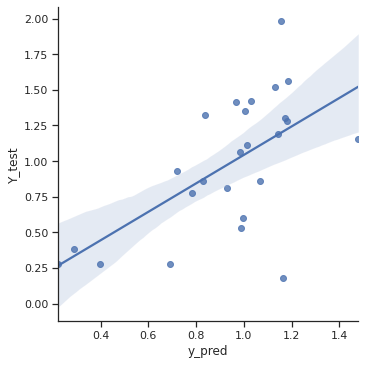

1
(97, 586)
(25, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', n_estimators=200,
                      n_jobs=30, random_state=44)
25
2-fold :  44.0
3-fold :  80.0
5-fold :  88.0
gmfe :  2.295768913949164
mfe :  1.3700217509906065
bias :  -0.5396772129082534
rmse  0.4726500804563337
r2  0.24771257203094754


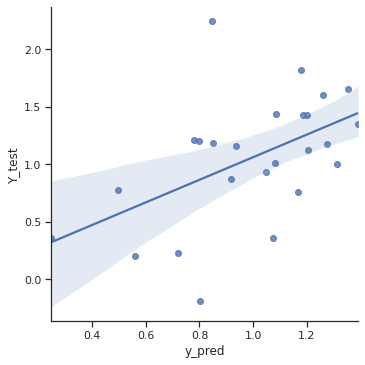

2
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=300,
                      n_jobs=30, random_state=44)
24
2-fold :  58.333333333333336
3-fold :  83.33333333333334
5-fold :  100.0
gmfe :  1.788628475268819
mfe :  1.243334720452576
bias :  -0.15369658157857335
rmse  0.3198529127849547
r2  0.678056704446783


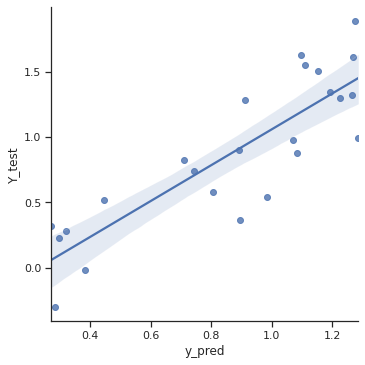

3
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
24
2-fold :  62.5
3-fold :  83.33333333333334
5-fold :  91.66666666666666
gmfe :  2.0496684275736494
mfe :  1.2967333816488162
bias :  -0.14387912450469864
rmse  0.3879885770492822
r2  0.3695766720318342


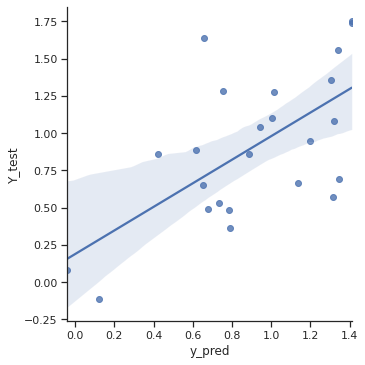

4
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=44)
24
2-fold :  45.83333333333333
3-fold :  75.0
5-fold :  79.16666666666666
gmfe :  2.5936476735761738
mfe :  1.3659869262593447
bias :  1.03806763150454
rmse  0.5272241529873762
r2  0.35958810555996146


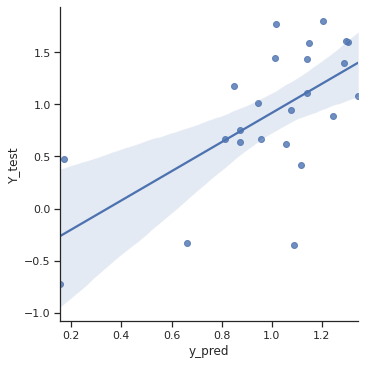

0
(97, 586)
(25, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=8,
                      n_jobs=30, random_state=45)
25
2-fold :  52.0
3-fold :  80.0
5-fold :  96.0
gmfe :  2.006363667417216
mfe :  1.320350799474224
bias :  1.0799090588713387
rmse  0.3708511653898885
r2  0.6067257758522384


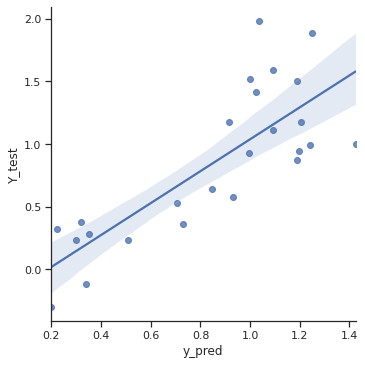

1
(97, 586)
(25, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=45)
25
2-fold :  60.0
3-fold :  80.0
5-fold :  88.0
gmfe :  2.0573335900005163
mfe :  1.2708123190153382
bias :  -2.5149397028797527
rmse  0.4004065381070601
r2  0.34235244829087375


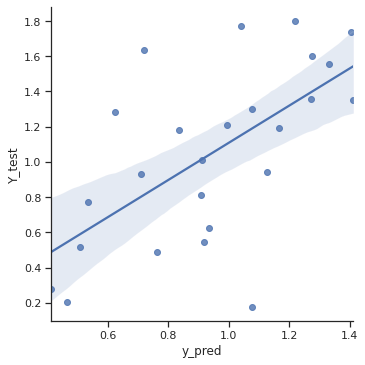

2
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=8,
                      n_jobs=30, random_state=45)
24
2-fold :  54.166666666666664
3-fold :  79.16666666666666
5-fold :  83.33333333333334
gmfe :  2.5279919887787763
mfe :  1.322971932380535
bias :  0.15877884107759088
rmse  0.5674956214158301
r2  0.28369117626642004


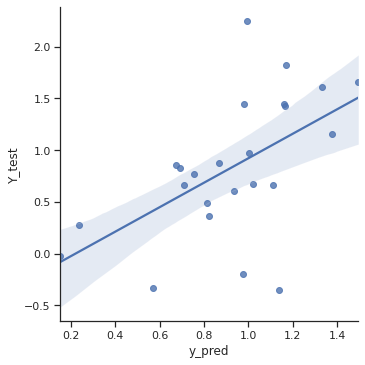

3
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', n_estimators=300,
                      n_jobs=30, random_state=45)
24
2-fold :  45.83333333333333
3-fold :  75.0
5-fold :  95.83333333333334
gmfe :  2.0344895025376633
mfe :  1.3741650315546285
bias :  -1.5358900388256669
rmse  0.37847380763933813
r2  0.25155136802029976


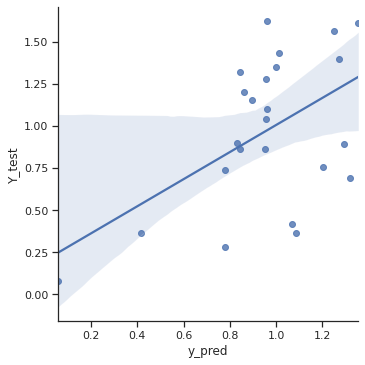

4
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=45)
24
2-fold :  62.5
3-fold :  87.5
5-fold :  91.66666666666666
gmfe :  1.799704666678686
mfe :  1.1850658449531417
bias :  -1.5963385712701448
rmse  0.34648042851286204
r2  0.5146861080303969


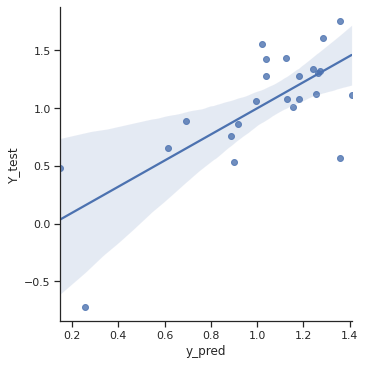

0
(97, 586)
(25, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=46)
25
2-fold :  64.0
3-fold :  96.0
5-fold :  100.0
gmfe :  1.7308882889498898
mfe :  1.2183029693464449
bias :  -0.5529728139830645
rmse  0.28803734151379845
r2  0.654304238316871
saving model


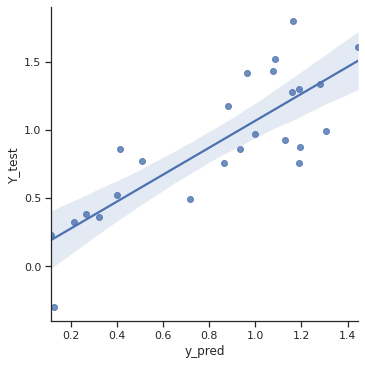

1
(97, 586)
(25, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=8, n_jobs=30, random_state=46)
25
2-fold :  52.0
3-fold :  84.0
5-fold :  92.0
gmfe :  2.176488544182449
mfe :  1.3500816433645597
bias :  -0.04722519295087113
rmse  0.4365839625857963
r2  0.3271355297658425


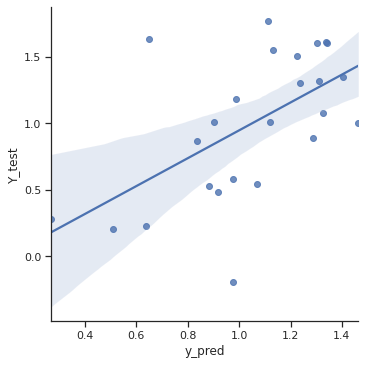

2
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=46)
24
2-fold :  50.0
3-fold :  75.0
5-fold :  87.5
gmfe :  2.3318289359411355
mfe :  1.3430087547460408
bias :  -1.7290900474240445
rmse  0.5065330368996394
r2  0.38237409076063666


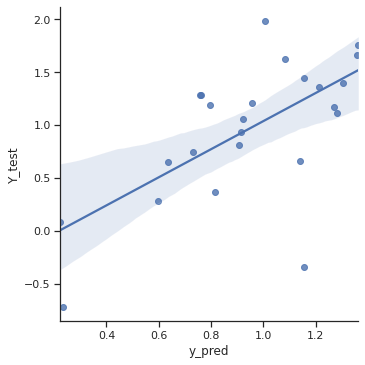

3
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=46)
24
2-fold :  37.5
3-fold :  70.83333333333334
5-fold :  87.5
gmfe :  2.575373842172318
mfe :  1.4474417241824267
bias :  0.46586979044753885
rmse  0.5027098245543069
r2  0.2559157181231997


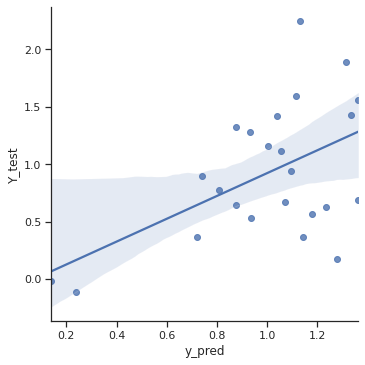

4
(98, 586)
(24, 586)
Running ____________________monkey_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=46)
24
2-fold :  66.66666666666666
3-fold :  87.5
5-fold :  95.83333333333334
gmfe :  1.8444978910788594
mfe :  1.216543970139005
bias :  -1.1615423640255282
rmse  0.3435885293916995
r2  0.5148833930692918


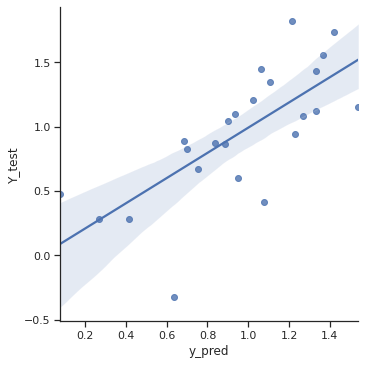

monkey_fup
0
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
17
2-fold :  47.05882352941176
3-fold :  58.82352941176471
5-fold :  70.58823529411765
gmfe :  3.670709694639107
mfe :  1.3515477020250142
bias :  0.17017257939060113
rmse  0.31174152441390923
r2  0.32101096469505686
saving model


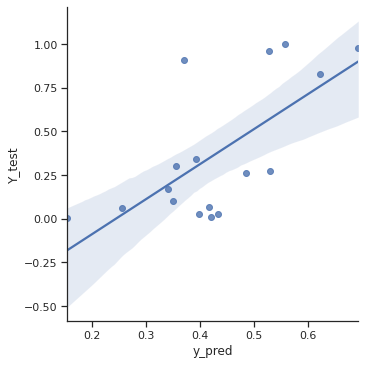

1
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      n_jobs=30, random_state=42)
17
2-fold :  76.47058823529412
3-fold :  94.11764705882352
5-fold :  94.11764705882352
gmfe :  1.7076336058166253
mfe :  1.1461206079432131
bias :  -0.11316522222222197
rmse  0.2911144733127746
r2  -0.03928471782840748
saving model


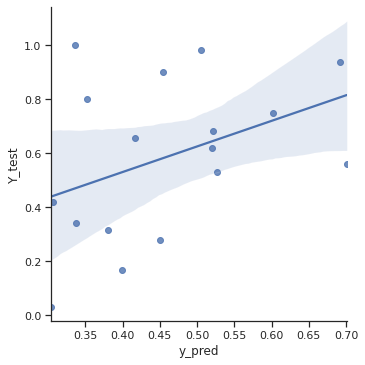

2
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=42)
17
2-fold :  52.94117647058824
3-fold :  70.58823529411765
5-fold :  82.35294117647058
gmfe :  2.919373902834723
mfe :  1.2845722720616932
bias :  0.05104363286028912
rmse  0.3050315274502719
r2  0.18578416709527945


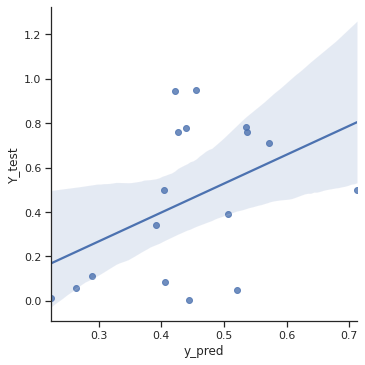

3
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='log2', min_samples_split=8,
                      n_jobs=30, random_state=42)
17
2-fold :  41.17647058823529
3-fold :  64.70588235294117
5-fold :  70.58823529411765
gmfe :  3.669419476678787
mfe :  1.4769329073949802
bias :  0.21416166143067444
rmse  0.3021140839638726
r2  0.19966591782097387


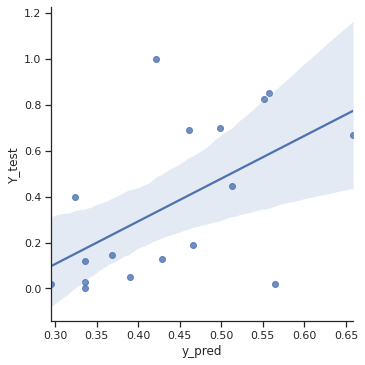

4
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_jobs=30,
                      random_state=42)
17
2-fold :  58.82352941176471
3-fold :  76.47058823529412
5-fold :  88.23529411764706
gmfe :  2.11127522171015
mfe :  1.2809317309962733
bias :  -0.05056755000000013
rmse  0.28484109285385395
r2  0.10136724744058112


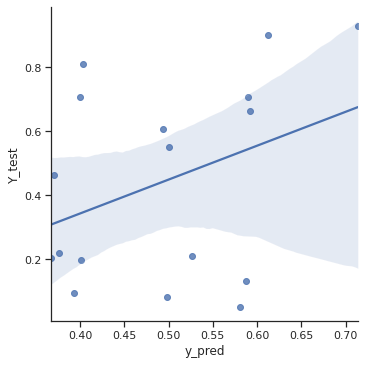

0
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='log2', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=43)
17
2-fold :  58.82352941176471
3-fold :  76.47058823529412
5-fold :  82.35294117647058
gmfe :  2.4617848817644368
mfe :  1.2251933481309505
bias :  -0.08462075538777852
rmse  0.285130155254505
r2  0.25259055054013746


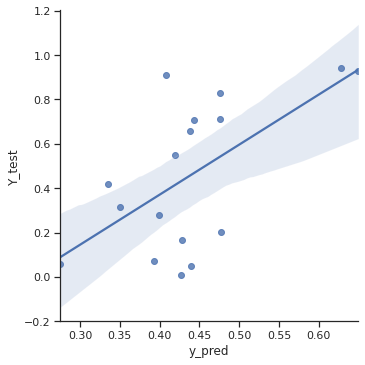

1
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='log2', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=43)
17
2-fold :  76.47058823529412
3-fold :  82.35294117647058
5-fold :  94.11764705882352
gmfe :  2.018274203617784
mfe :  1.313745160339799
bias :  0.13285876660607848
rmse  0.27985960496154166
r2  0.17000271557772562


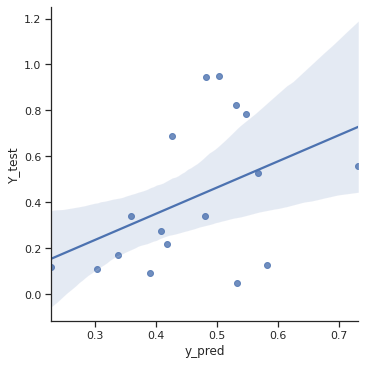

2
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=43)
17
2-fold :  52.94117647058824
3-fold :  64.70588235294117
5-fold :  64.70588235294117
gmfe :  3.3438573065178465
mfe :  1.2531683075317155
bias :  0.19012633789129363
rmse  0.2881309407118574
r2  0.311466748014098


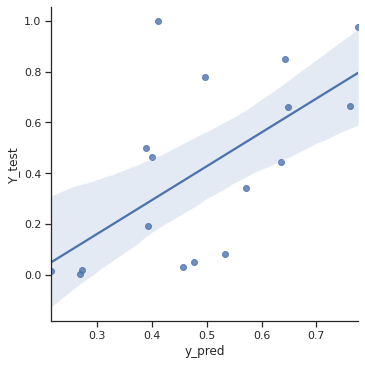

3
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
17
2-fold :  58.82352941176471
3-fold :  70.58823529411765
5-fold :  88.23529411764706
gmfe :  2.7284349849188683
mfe :  1.3114781722978093
bias :  0.13405749999999989
rmse  0.2939597042978853
r2  0.09289377697672285


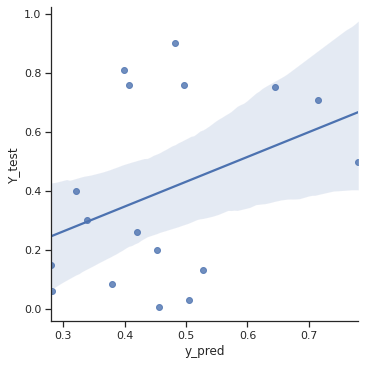

4
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', n_jobs=30,
                      random_state=43)
17
2-fold :  52.94117647058824
3-fold :  70.58823529411765
5-fold :  76.47058823529412
gmfe :  3.233132571440244
mfe :  1.3299031491742939
bias :  -0.10226485986291489
rmse  0.3590243945637065
r2  0.10651897401540489


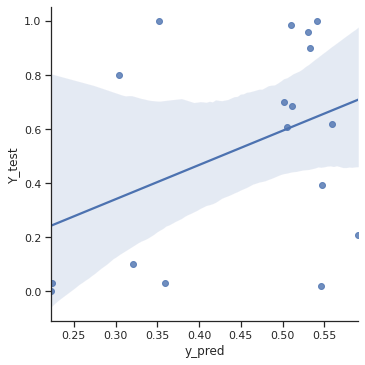

0
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=44)
17
2-fold :  52.94117647058824
3-fold :  76.47058823529412
5-fold :  88.23529411764706
gmfe :  2.3829822612342686
mfe :  1.2684077065026034
bias :  0.01693369345238077
rmse  0.35229419563913744
r2  -0.05248479259225891


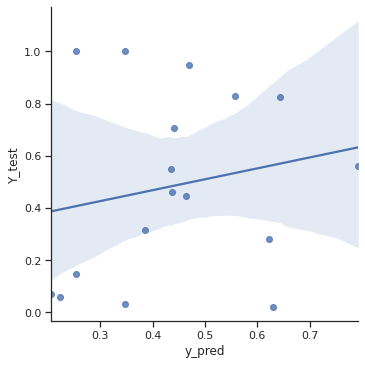

1
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
17
2-fold :  64.70588235294117
3-fold :  76.47058823529412
5-fold :  76.47058823529412
gmfe :  3.189383283650856
mfe :  1.2146140237144423
bias :  0.09988263519668694
rmse  0.20984012791961507
r2  0.537030629813509


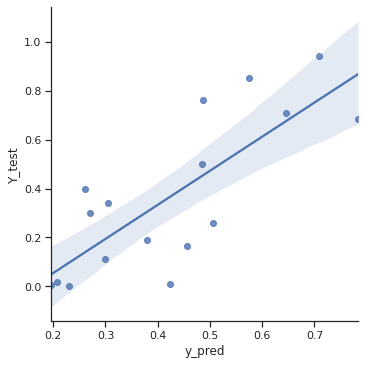

2
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=44)
17
2-fold :  52.94117647058824
3-fold :  70.58823529411765
5-fold :  76.47058823529412
gmfe :  2.6049096074049736
mfe :  1.225042310069834
bias :  -0.030652500000000638
rmse  0.3414696543065235
r2  0.10604631680211007


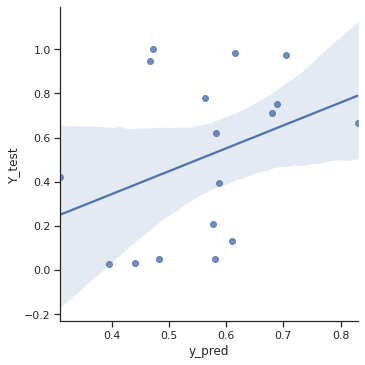

3
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=44)
17
2-fold :  70.58823529411765
3-fold :  76.47058823529412
5-fold :  88.23529411764706
gmfe :  2.0634470642514118
mfe :  1.3023965329328206
bias :  -0.09501670714285715
rmse  0.32033774605560267
r2  -0.04914545927240899


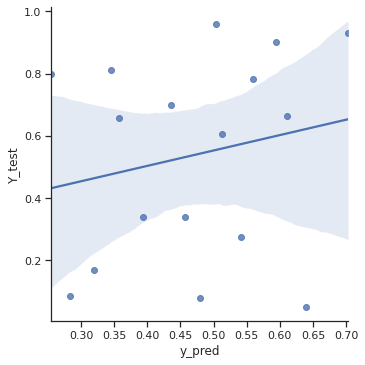

4
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
17
2-fold :  47.05882352941176
3-fold :  58.82352941176471
5-fold :  70.58823529411765
gmfe :  3.411468599886849
mfe :  1.4967934184735088
bias :  0.18393278443226274
rmse  0.31304592278893767
r2  -0.011881071543231592


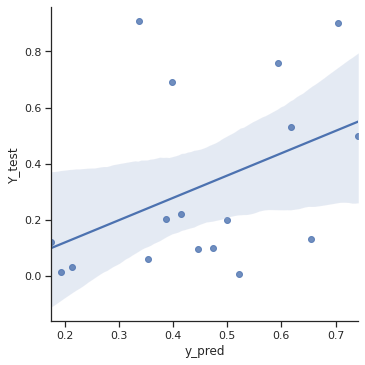

0
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=45)
17
2-fold :  47.05882352941176
3-fold :  76.47058823529412
5-fold :  88.23529411764706
gmfe :  2.4672994258025955
mfe :  1.3781804558348227
bias :  0.15979300000000002
rmse  0.3359655969207395
r2  -0.0553023676666613


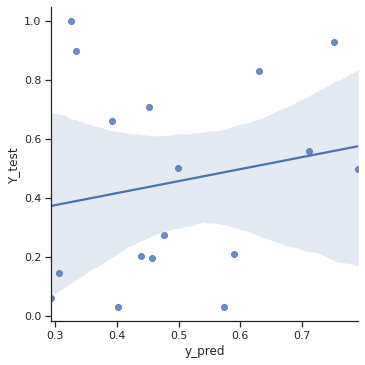

1
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
17
2-fold :  58.82352941176471
3-fold :  70.58823529411765
5-fold :  76.47058823529412
gmfe :  2.863210248739086
mfe :  1.2251326930881563
bias :  0.05777099999999992
rmse  0.2910501899627675
r2  0.20451465558829174


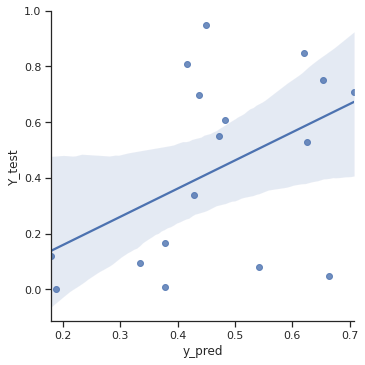

2
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
17
2-fold :  64.70588235294117
3-fold :  82.35294117647058
5-fold :  94.11764705882352
gmfe :  2.005054456279948
mfe :  1.2574136832905987
bias :  -0.22564762743676636
rmse  0.31595072173105065
r2  -0.1750813852887536


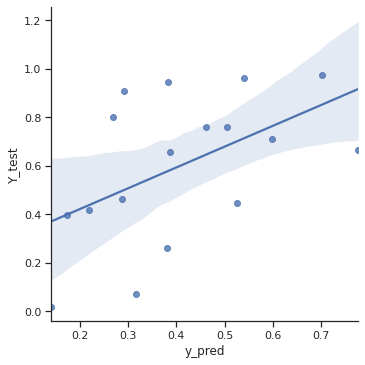

3
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=45)
17
2-fold :  58.82352941176471
3-fold :  70.58823529411765
5-fold :  82.35294117647058
gmfe :  2.8307592010918783
mfe :  1.1406196811088638
bias :  0.05425402938649232
rmse  0.25787306763052686
r2  0.2941099525475761


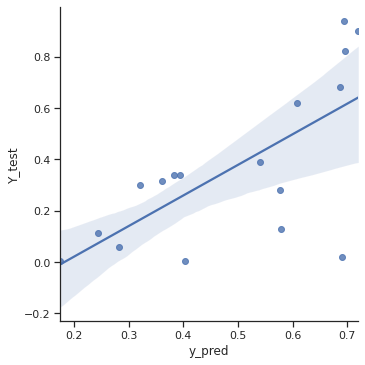

4
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_jobs=30,
                      random_state=45)
17
2-fold :  29.411764705882355
3-fold :  52.94117647058824
5-fold :  70.58823529411765
gmfe :  3.5654796291394684
mfe :  1.439834656702943
bias :  0.205969
rmse  0.34114976632041033
r2  0.20233754733150844


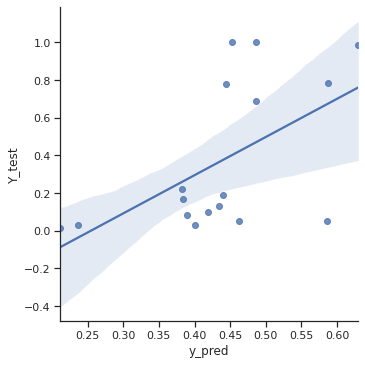

0
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
17
2-fold :  58.82352941176471
3-fold :  64.70588235294117
5-fold :  70.58823529411765
gmfe :  3.2729978469750765
mfe :  1.2092250978241634
bias :  0.12828420745356905
rmse  0.3247961606705147
r2  -0.0990248369190716


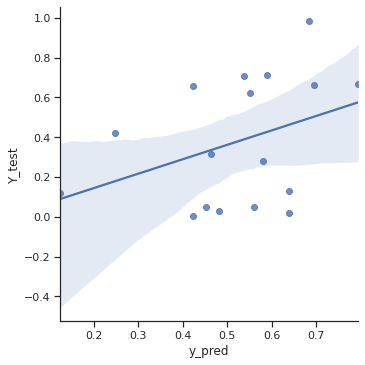

1
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', n_jobs=30,
                      random_state=46)
17
2-fold :  64.70588235294117
3-fold :  82.35294117647058
5-fold :  82.35294117647058
gmfe :  2.268670817588551
mfe :  1.2414581508629396
bias :  0.07188105354700969
rmse  0.26649676341541795
r2  0.3365306855372776


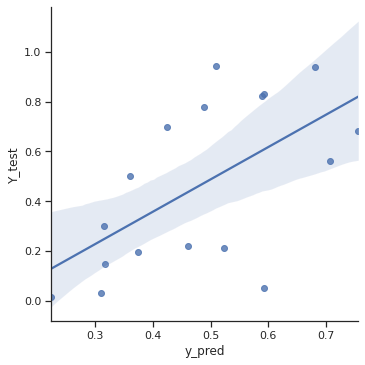

2
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=46)
17
2-fold :  58.82352941176471
3-fold :  70.58823529411765
5-fold :  82.35294117647058
gmfe :  2.5243604050105364
mfe :  1.3234552160595483
bias :  0.08612032801751002
rmse  0.3026610279052248
r2  0.1563306927623379


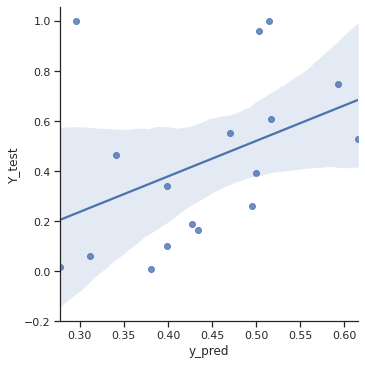

3
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='sqrt', n_jobs=30,
                      random_state=46)
17
2-fold :  58.82352941176471
3-fold :  76.47058823529412
5-fold :  88.23529411764706
gmfe :  2.4781119708792874
mfe :  1.2842883487955596
bias :  -0.14173533986614223
rmse  0.27900031565819355
r2  0.284121623302903


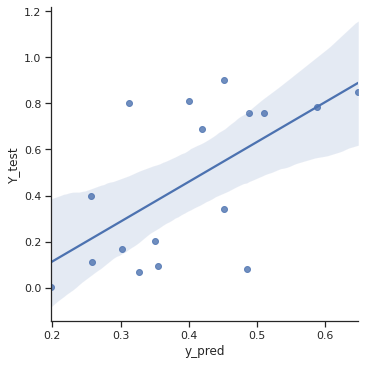

4
(68, 586)
(17, 586)
Running ____________________monkey_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=46)
17
2-fold :  47.05882352941176
3-fold :  64.70588235294117
5-fold :  82.35294117647058
gmfe :  2.788080669272137
mfe :  1.3736365251181188
bias :  0.02752846190476166
rmse  0.31868280297092366
r2  0.30999096546534655


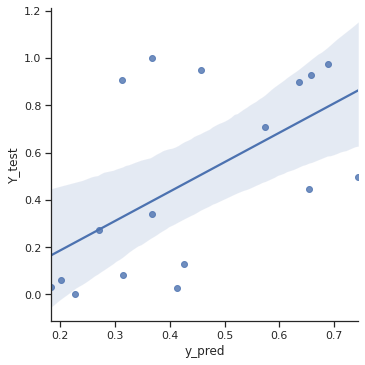

In [17]:
from sklearn.preprocessing import StandardScaler
import pickle
list_of_lists=[]

for endpoint in ["monkey_VDss_L_kg","monkey_CL_mL_min_kg","monkey_fup"]: 
    
    #log human_VDss_L_kg model
    data = monkey_mfp_Mordred
    features = features_mfp_mordred_columns
    baseline=10.00

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)
    X = df[features]
    Y = df[endpoint]
        
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features)
    
    for i in range(42,47):

        #Nested Cross Validation    
        outercv = KFold(n_splits=5, random_state=i, shuffle=True) 

        for split, (train_index, test_index) in enumerate(outercv.split(X)):
            print(split)

            X_train= X.iloc[train_index].values
            Y_train= Y.iloc[train_index].values.flatten()

            X_test= X.iloc[test_index].values
            Y_test= Y.iloc[test_index].values.flatten()

            print(X_train.shape)
            print(X_test.shape)

            inner_cv = KFold(n_splits=4, random_state=i, shuffle=True) 

            # Create a based model
            regressor = RandomForestRegressor(random_state = i, n_jobs=20)

            # Instantiate the RandomHalving search model
            param_grid = { 
            "n_estimators": [100,200,300],
            "max_features": ["sqrt", "log2"],
            "min_samples_split": [2,4,8],
            "max_depth": [5, 10, 15],    
            "bootstrap": [True, False],
            'n_jobs': [30]
            }

            gsh = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = inner_cv, n_jobs=30, verbose = 1)

            ##MODELS
            print(f"Running ____________________{endpoint} MODELS")

            gsh.fit(X_train, Y_train)
            #print(gsh.best_estimator_)

            #HeldOutTest
            classifier = gsh.best_estimator_
            print(classifier)
            classifier.fit(X_train, Y_train)

            y_pred =  classifier.predict(X_test)     
            print(len(y_pred))

            fold_2= count(y_pred, Y_test, 0.5, 2, endpoint)
            fold_3= count(y_pred, Y_test, 1/3, 3, endpoint)
            fold_5= count(y_pred, Y_test, 1/5, 5, endpoint)
            gmfe = calc_gmfe(y_pred, Y_test, endpoint)
            mfe = median_fold_change_error(y_pred, Y_test, endpoint)
            bias = calc_bias(y_pred, Y_test, endpoint)

            print("2-fold : ", fold_2)
            print("3-fold : ", fold_3)
            print("5-fold : ", fold_5)
            print("gmfe : ", gmfe)
            print("mfe : ", mfe)
            print("bias : ", bias)

            rmse = sqrt(mean_squared_error(Y_test, y_pred))
            print('rmse ',rmse)
            r2 = r2_score(Y_test, y_pred)
            print('r2 ',r2)

            #if (r2>baseline):
            if (gmfe<baseline):
                # save
                print("saving model")
                baseline=gmfe
                pickle.dump(classifier, open(f"log_{endpoint}_model.sav", 'wb'))

            sns.set_theme(style="ticks")
            df=pd.DataFrame({"y_pred":y_pred, "Y_test":Y_test})
            sns.lmplot(data=df, x="y_pred", y="Y_test")
            
            plt.show()

            row=["HeldOut",  endpoint, i, split, fold_2, fold_3, fold_5, gmfe, mfe, bias, rmse, r2]
            list_of_lists.append(row)


In [18]:
results = pd.DataFrame(list_of_lists, columns=["HeldOut", "endpoint", "random_state", "split", "fold_2", "fold_3", "fold_5", "gmfe", "mfe", "bias", "rmse", "r2"])
results

,HeldOut,endpoint,random_state,split,fold_2,fold_3,fold_5,gmfe,mfe,bias,rmse,r2
0,HeldOut,monkey_VDss_L_kg,42,0,70.833333,79.166667,91.666667,1.832720,1.162140,-0.028289,0.368636,0.608831
1,HeldOut,monkey_VDss_L_kg,42,1,66.666667,75.000000,83.333333,2.072574,1.235456,0.037834,0.447525,0.470761
2,HeldOut,monkey_VDss_L_kg,42,2,75.000000,79.166667,91.666667,1.984102,1.227709,0.051326,0.427874,0.506938
3,HeldOut,monkey_VDss_L_kg,42,3,65.217391,82.608696,86.956522,2.276584,1.263885,0.270346,0.480402,0.118216
4,HeldOut,monkey_VDss_L_kg,42,4,43.478261,56.521739,82.608696,2.565174,1.513068,0.094883,0.504659,0.408727
...,...,...,...,...,...,...,...,...,...,...,...,...
70,HeldOut,monkey_fup,46,0,58.823529,64.705882,70.588235,3.272998,1.209225,0.128284,0.324796,-0.099025
71,HeldOut,monkey_fup,46,1,64.705882,82.352941,82.352941,2.268671,1.241458,0.071881,0.266497,0.336531
72,HeldOut,monkey_fup,46,2,58.823529,70.588235,82.352941,2.524360,1.323455,0.086120,0.302661,0.156331
73,HeldOut,monkey_fup,46,3,58.823529,76.470588,88.235294,2.478112,1.284288,-0.141735,0.279000,0.284122


In [19]:
results.to_csv("Prediction_monkey_from_mordred_morgan_fs.csv", index=False)

In [20]:
import pandas as pd
results= pd.read_csv("Prediction_monkey_from_mordred_morgan_fs.csv")
results.groupby("endpoint").mean().reset_index().to_csv("monkey.csv", index=False)
results.groupby("endpoint").mean()

,random_state,split,fold_2,fold_3,fold_5,gmfe,mfe,bias,rmse,r2
endpoint,,,,,,,,,,
monkey_CL_mL_min_kg,44.0,2.0,52.100000,79.613333,91.273333,2.144427,1.315102,-0.528769,0.420808,0.387215
monkey_VDss_L_kg,44.0,2.0,60.811594,75.702899,87.601449,2.138132,1.263926,0.043905,0.441473,0.443747
monkey_fup,44.0,2.0,56.470588,72.000000,81.176471,2.743204,1.294164,0.045644,0.302862,0.147604


In [21]:
# load
loaded_rf = pickle.load(open("log_monkey_VDss_L_kg_model.sav", 'rb'))

In [22]:
loaded_rf

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)

In [23]:
import pickle
list_of_lists=[]


for endpoint in ["monkey_VDss_L_kg","monkey_CL_mL_min_kg","monkey_fup"]:
    
    baseline=10.00
    #log human_VDss_L_kg model
    data = monkey_mfp_Mordred
    features = features_mfp_mordred_columns
        

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    X = df[features]
    Y = df[endpoint]

    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features)
    
    # Save the scaler to a file
    with open('scaler_monkey.pkl', 'wb') as file:
        pickle.dump(scaler, file)
    
    X_train= X.values
    Y_train= Y.values.flatten()

    print(X_train.shape)
    print(X_test.shape)

          
    loaded_rf = pickle.load(open(f"log_{endpoint}_model.sav", 'rb'))

    
    params = loaded_rf.get_params()
    
    classifier= RandomForestRegressor(**params)
    classifier.fit(X_train, Y_train)
    
    pickle.dump(classifier, open(f"log_{endpoint}_model_FINAL.sav", 'wb'))

monkey_VDss_L_kg
(118, 586)
(17, 586)
monkey_CL_mL_min_kg
(122, 586)
(17, 586)
monkey_fup
(85, 586)
(17, 586)
